## Prediction with Expectation Reflection

In the following, we demonstrate how to apply Expectation Reflection (ER) for classification task such as medical diagnosis.

We import the necessary packages to the Jupyter notebook:

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split,KFold
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,\
recall_score,roc_curve,auc

import expectation_reflection as ER

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from function import split_train_test,make_data_balance

In [2]:
np.random.seed(1)

First of all, the processed data are imported.

In [3]:
Xy = np.loadtxt('data_processed.dat') 
X = Xy[:,:-1]
y = Xy[:,-1]

We take a look number of samples for each class.

In [4]:
print(np.unique(y,return_counts=True))

(array([0., 1.]), array([149, 223]))


We may consider to make balance for the data, this can be `under sampling` or `over sampling`. We select `under sampling` in this Jupyter Notebook.

In [5]:
X,y = make_data_balance(X,y)

In [6]:
print(np.unique(y,return_counts=True))

(array([0., 1.]), array([149, 149]))


Shuffle the data.

In [7]:
X, y = shuffle(X, y, random_state=1)

We split data into training and test sets, then we use the training to train our model, use the test set to evaluate the performance of our method. The size of test set can be changed by `test_size`.

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,random_state = 1)

We rescale the training set and test set separately.

In [9]:
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

We now train model with the `X_train` and `y_train`. Please note that our model has one hyper parameter `l2`. We will use cross validation to find the optimal value of `l2`. This process will also split the training set again into `X_train1` and `X_val`. The test set is assumed to be unknown and is not used in the training process.

In [10]:
n = X_train.shape[1]

l2 = [0.01,0.1,1.,10.,100.]
nl2 = len(l2)

# cross validation 
kf = 4   
kfold = KFold(n_splits=kf,shuffle=False,random_state=1)

h01 = np.zeros(kf)
w1 = np.zeros((kf,n))
cost1 = np.zeros(kf)

h0 = np.zeros(nl2)
w = np.zeros((nl2,n))
cost = np.zeros(nl2)            
for il2 in range(len(l2)):            
    for i,(train_index,val_index) in enumerate(kfold.split(y_train)):
        X_train1, X_val = X_train[train_index], X_train[val_index]
        y_train1, y_val = y_train[train_index], y_train[val_index]
        h01[i],w1[i,:] = ER.fit(X_train1,y_train1,niter_max=100,l2=l2[il2])

        y_val_pred,p_val_pred = ER.predict(X_val,h01[i],w1[i])
        cost1[i] = ((p_val_pred - y_val)**2).mean()

    h0[il2] = h01.mean(axis=0)
    w[il2,:] = w1.mean(axis=0)
    cost[il2] = cost1.mean()

In [11]:
# optimal value of l2:
il2_opt = np.argmin(cost)
print('optimal l2:',l2[il2_opt])

optimal l2: 1.0


Now, it is time to play with the test set. We will use the bias `h0` and interactions `w` given from the optimal `l2` to predict the output `y_test_pred` of input `X_test`.

In [12]:
y_test_pred,p_test_pred = ER.predict(X_test,h0[il2_opt],w[il2_opt,:])

We will estimate the prediction performance base on serveral metrics, including AUC, accuracy, precision, and recall.

In [13]:
fp,tp,thresholds = roc_curve(y_test, p_test_pred, drop_intermediate=False)

Text(0, 0.5, 'True positive rate')

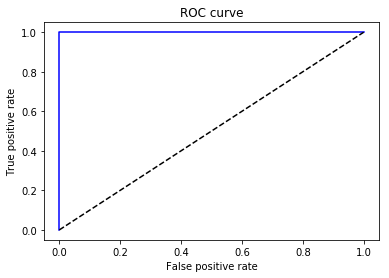

In [14]:
plt.plot(fp,tp,'b-')
plt.plot([0,1],[0,1],'k--')
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

In [15]:
roc_auc = auc(fp,tp)
print('AUC:', roc_auc)

AUC: 0.9999999999999999


In [16]:
acc = accuracy_score(y_test,y_test_pred)
print('Accuracy:', acc)

Accuracy: 0.9664429530201343


In [17]:
precision = precision_score(y_test,y_test_pred)
print('Precision:',precision)

Precision: 1.0


In [18]:
recall = recall_score(y_test,y_test_pred)
print('Recall:',recall)

Recall: 0.927536231884058


The peformance for each class is shown in detail by the confusion matrix.

Text(0.5, 15.0, 'Predicted label')

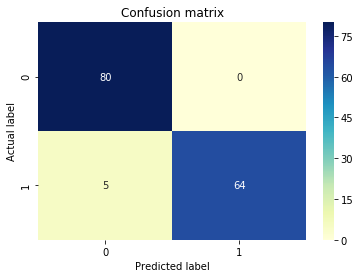

In [19]:
cnf_matrix = confusion_matrix(y_test, y_test_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')